# Aligning
`align` is a module for aligning two separated datasets together, in order to have better comparison of the data. The main idea is to get a matrix $Q$ from the input data sets $X$ and $Y$, Then use $Q$ for aligning $X$ to where $Y$ is. The differences among classes in `align` is the principle of how we get the orthogonal matrix $Q$ from inputs. For more information about the algorithm of these classes, see [reference](https://graspy.neurodata.io/reference/align.html).

This demo shows simple examples of how to use SignFlips, SeedlessProcrustes, and OrthogonalProcrustes in `align`, and the differences in settings, in the situations where each of these classes is appropriate.

In [1]:
import graspologic
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import special_ortho_group

%matplotlib inline

## Simple rotation example for each classes

This part mainly explains how to use SignFlips, SeedlessProcrustes, and OrthogonalProcrustes. First, let's build two simple datasets, where $Y$ is a a copy of $X$, randomly rotated around the origin.

In [2]:
np.random.seed(1)
X = np.random.rand(10, 2)
Z = special_ortho_group.rvs(2)
Y = X @ Z

Then polt $X$ and $Y$ to see how they look like.

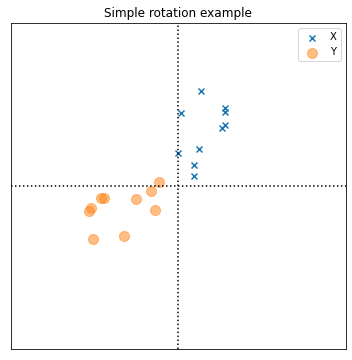

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title("Simple rotation example")
ax.scatter(X[:,0], X[:,1], label="X", marker='x')
ax.scatter(Y[:,0], Y[:,1], label="Y", s=100, alpha=0.5)
ax.set(xlim=(-1.50, 1.50), ylim=(-1.50, 1.50))
ax.axvline(color="black", linestyle=":")
ax.axhline(color="black", linestyle=":")
ax.set_xticks([])
ax.set_yticks([])
ax.legend();

Then use different classes in Aligning for aligning $X$ back with $Y$. Let's see the different performances between classes.

### SignFlips

In essence, SignFlips is a function for fliping one dataset $X$, to another dimension. A diagonal orthogonal matrix $Q$ will be generated based on $X$ and $Y$. By $XQ$, All the enteries in $X$ are fliped along axises, to get it to the quadrant where $Y$ is. 

Here we introduce SignFlips to get the fliped dataset, $X_{SF}$.

In [4]:
from graspologic.align import SignFlips
X_prime_SignFlips = SignFlips().fit_transform(X, Y)

Then plot $X$, $Y$, $X_{SF}$

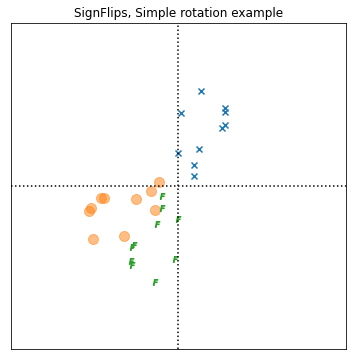

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title("SignFlips, Simple rotation example")
ax.scatter(X[:,0], X[:,1], label="X", marker='x')
ax.scatter(Y[:,0], Y[:,1], label="Y", s=100, alpha=0.5)
ax.scatter(X_prime_SignFlips[:,0], X_prime_SignFlips[:,1], label="X_SF", 
            marker='$F$')
ax.set(xlim=(-1.50, 1.50), ylim=(-1.50, 1.50))
ax.axvline(color="black", linestyle=":")
ax.axhline(color="black", linestyle=":")
ax.set_xticks([])
ax.set_yticks([])
ax.grid();

Here we can see, SignFlips simply filped $X$ along x-axis and y-axis to get $X_{SF}$ to the third quadrant, the quadrant where $Y$ is. There is no further algning for this class. This class can also be used to bring the dataset to the first orthant, if you provide the identity matrix as the second dataset.

### OrthogonalProcrustes

OrthogonalProcrustes is a wrapper of  *[scipy.linal.orthogonal_procrustes()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.orthogonal_procrustes.html)*. This class is based on the solution of classical orthogonal procrustes problem. The classical orthogonal procrustes problem is a matrix approximation problem in linear algebra, as one is asked to find a orthogonal matrix $Q$, which could most closely maps the given matrix $X$ to another given matrix $Y$. Since the orthogonal procrustes problem strongly relies on the correspondence between the rows of the given matrices, this class can only be applied when the entery datasets $X$ and $Y$ have the equal shape ($n$, $d$). This means the vertex $i$ in graph $X$ has the same latent position as the vertex $i$ in graph $Y$ in graph embedings. 

Here we use OrthogonalProcrustes to get the transformed dataset, $X_{OP}$.

In [6]:
from graspologic.align import OrthogonalProcrustes
X_prime_Orthogonal = OrthogonalProcrustes().fit_transform(X, Y)

Plot $X$, $Y$, $X_{OP}$.

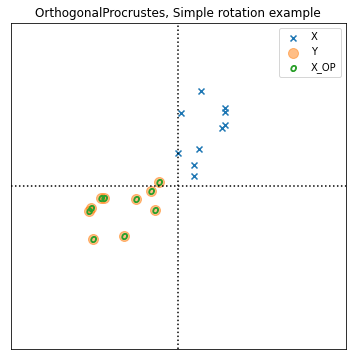

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title("OrthogonalProcrustes, Simple rotation example")
ax.scatter(X[:,0], X[:,1], label="X", marker='x')
ax.scatter(Y[:,0], Y[:,1], label="Y", s=100, alpha=0.5)
ax.scatter(X_prime_Orthogonal[:,0], X_prime_Orthogonal[:,1], label="X_OP", 
            marker='$O$')
ax.set(xlim=(-1.50, 1.50), ylim=(-1.50, 1.50))
ax.axvline(color="black", linestyle=":")
ax.axhline(color="black", linestyle=":")
ax.set_xticks([])
ax.set_yticks([])
ax.legend();

As shown in the figure above, OrthogonalProcrustes have excellent performance when aligning $X$ to $Y$.

### SeedlessProcrustes

SeedlessProcrustes try to get the matrix $Q$ via an iterative algorithm that alternates optimal transport and regular procrustes.
It is not restricted by the shape diferences between datasets, i.e., it can be applied to two datasets with/without the same number of entries regardless whether there is correspondence between entries or not. 

Here we use it for aligning the two same datasets $X$, $Y$ showed above. Introduce SeedlessProcrustes to get the transformed dataset, $X_{SP}$.

In [8]:
from graspologic.align import SeedlessProcrustes
X_prime_Seedless = SeedlessProcrustes().fit_transform(X, Y)

Plot $X$, $Y$, $X_{SP}$.

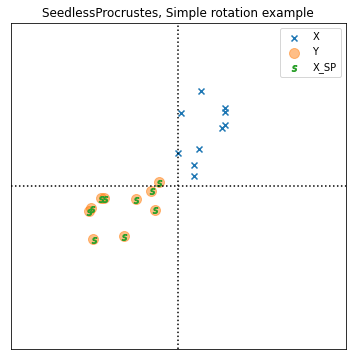

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title("SeedlessProcrustes, Simple rotation example")
ax.scatter(X[:,0], X[:,1], label="X", marker='x')
ax.scatter(Y[:,0], Y[:,1], label="Y", s=100, alpha=0.5)
ax.scatter(X_prime_Seedless[:,0], X_prime_Seedless[:,1], label="X_SP", 
            marker='$S$')
ax.set(xlim=(-1.50, 1.50), ylim=(-1.50, 1.50))
ax.axvline(color="black", linestyle=":")
ax.axhline(color="black", linestyle=":")
ax.set_xticks([])
ax.set_yticks([])
ax.legend();

This figure represent that SeedlessProcrustes can also align $X$ well with $Y$.

### Comparison between SignFlips, OrthogonalProcrustes, SeedlessProcrustes

Here we plot the outcomes of three classes in simple rotation example together, to have a clearer comparison of them.

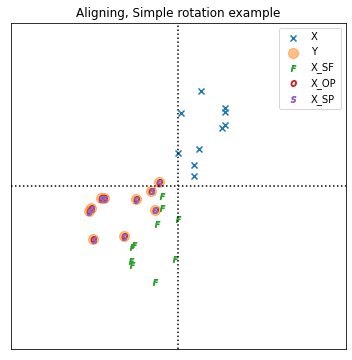

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title("Aligning, Simple rotation example")
ax.scatter(X[:,0], X[:,1], label="X", marker='x')
ax.scatter(Y[:,0], Y[:,1], label="Y", s=100, alpha=0.5)
ax.scatter(X_prime_SignFlips[:,0], X_prime_SignFlips[:,1], 
            label="X_SF", marker='$F$')
ax.scatter(X_prime_Orthogonal[:,0], X_prime_Orthogonal[:,1], 
            label="X_OP", marker='$o$')
ax.scatter(X_prime_Seedless[:,0], X_prime_Seedless[:,1], 
            label="X_SP", marker='$S$')
ax.set(xlim=(-1.50, 1.50), ylim=(-1.50, 1.50))
ax.axvline(color="black", linestyle=":")
ax.axhline(color="black", linestyle=":")
ax.set_xticks([])
ax.set_yticks([])
ax.legend();

Introduce *[np.linlg.norm()](https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html)* to calculate the Frobenius norm of ($X_{prime}$ - $Y$), for quantificaion of the aligning ability in this example.

In [11]:
norm_SignFlips = np.linalg.norm(X_prime_SignFlips - Y)
norm_Orthogonal = np.linalg.norm(X_prime_Orthogonal - Y)
norm_Seedless = np.linalg.norm(X_prime_Seedless - Y)
print('norm_SignFlips=', norm_SignFlips)
print('norm_Orthogonal=', norm_Orthogonal)
print('norm_Seedless=', norm_Seedless)

norm_SignFlips= 1.4779981074320632
norm_Orthogonal= 3.437379846455101e-16
norm_Seedless= 0.02152739003460826


SignFlips only do the simple flips of datasets along axises. Both OrthogonalProcrustes and SeedlessProcrustes align $X$ very well with the exact palce and distribution of $Y$. 

## Special example for SignFlips and SeedlessProcrustes

This part includes two special example for SignFlips and SeedlessProcrustes respectively, for better presenting their functions.

### Simple fliping example for SignFlips 

For better understanding of how exactly SignFlips works, here is an example of using SignFlips in simple-fliping situation. In this example, $Y$ is a set rotated by 180 degree from $X$. 

In [12]:
np.random.seed(1)
X = np.random.rand(10, 2)
Y = -X

Use SignFlips to get the fliped dataset, $X_{SF}$, and then plot out.

In [13]:
from graspologic.align import SignFlips
X_prime_SignFlips = SignFlips().fit_transform(X, Y)

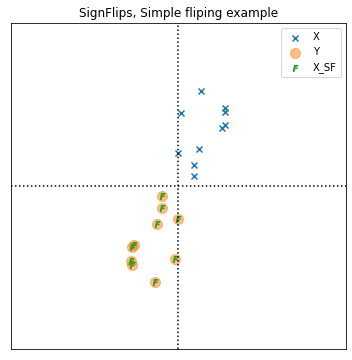

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title("SignFlips, Simple fliping example")
ax.scatter(X[:,0], X[:,1], label="X", marker='x')
ax.scatter(Y[:,0], Y[:,1], label="Y", s=100, alpha=0.5)
ax.scatter(X_prime_SignFlips[:,0], X_prime_SignFlips[:,1], label="X_SF", 
            marker='$F$')
ax.set(xlim=(-1.50, 1.50), ylim=(-1.50, 1.50))
ax.axvline(color="black", linestyle=":")
ax.axhline(color="black", linestyle=":")
ax.set_xticks([])
ax.set_yticks([])
ax.legend();

Introduce np.linlg.norm to calculate the Frobenius norm of ($X_{prime}$ - $Y$), for quantificaion of the aligning ability in this example.

In [15]:
norm_SignFlips = np.linalg.norm(X_prime_SignFlips - Y)
print('norm_SignFlips=', norm_SignFlips)

norm_SignFlips= 0.0


Since SignFlips only do the simple flips of datasets along axises, and that's how $Y$ comes from in this example, norm_SignFlips is 0, i.e. $Y$ is perfectly overlaped by $X_{SF}$. 

### Unmatched input example for Seedlessprocrustes

As mentioned above, SeedlessProcrustes can be applied to two datasets with different number of entries. Here an example for using it on two unmatched input datasets.

First, create two sample from multivariate normal distribution (MVN).

In [16]:
np.random.seed(1)
I = np.identity(2)
Z = special_ortho_group.rvs(2)
X = np.random.multivariate_normal([0.5, 0.5], 0.05 * I, 20)
Y = np.random.multivariate_normal([0.5, 0.5], 0.05 * I, 10) @ Z

Introduce SeedlessProcrustes to get the transformed dataset, $X_{Seedless}$, and then plot out.

In [17]:
from graspologic.align import SeedlessProcrustes
X_prime_Seedless = SeedlessProcrustes().fit_transform(X, Y)

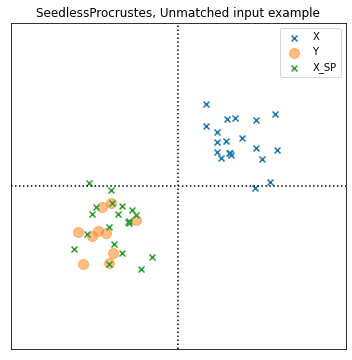

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_title("SeedlessProcrustes, Unmatched input example")
ax.scatter(X[:,0], X[:,1], label="X", marker='x')
ax.scatter(Y[:,0], Y[:,1], label="Y", s=100, alpha=0.5)
ax.scatter(X_prime_Seedless[:,0], X_prime_Seedless[:,1], label="X_SP", 
           marker='x')
ax.set(xlim=(-1.50, 1.50), ylim=(-1.50, 1.50))
ax.axvline(color="black", linestyle=":")
ax.axhline(color="black", linestyle=":")
ax.set_xticks([])
ax.set_yticks([])
ax.legend();